## Choosing the right ML algorithms

To be able to choose the right machine learning models, we need to formulate a clear and concise description of our problem. We would like to predict cancer malignancy (diagnosis) by looking at the size of cell features from images of cell substracts. The features of the cells concern the mean texture, mean radius, area, concavity and other geometrical features of the cells themself. With that said, the task of predicting whether a cancer diagnosis is malignant or benign, is clearly a classification task. 

Since in our dataset we already have the labeled diagnosis, it seems prudent to test some of the supervised models which scikit-learn offers.

In [2]:
# Load data
import pandas as pd
import matplotlib.pyplot as plt

# Read dataset
data_breast_cancer = pd.read_csv("breast_cancer_win/data.csv")

# data (as pandas dataframes)
print(data_breast_cancer.shape)
features = data_breast_cancer.columns
print(len(features))

print("Data features: \n", features)
print(data_breast_cancer.describe())

# Prepare the dataset

means_labels : list[str] = list(data_breast_cancer.columns[1:11])
worst_labels : list[str] = list(data_breast_cancer.columns[-10: -1])

# Drop the faulty column
data_breast_cancer.drop(columns=["Unnamed: 32", "id"], inplace=True)

# Set the data diagnosis results to integers
data_breast_cancer['diagnosis'] = data_breast_cancer['diagnosis'].map({"M":1,"B":0})
# split dataframe into two based on diagnosis
dfM=data_breast_cancer[data_breast_cancer['diagnosis'] == 1]
dfB=data_breast_cancer[data_breast_cancer['diagnosis'] == 0]

# Copy result array and drop it from our dataset
y_all = data_breast_cancer["diagnosis"].copy()
data_breast_cancer.drop(columns=["diagnosis"], inplace=True)



(569, 33)
33
Data features: 
 Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')
                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351

In [3]:
# Split the data into 3 categories: models can perform differently based on which data we feed them!
data_breast_means = data_breast_cancer[data_breast_cancer.columns[0: 10]].copy()
data_breast_worst = data_breast_cancer[data_breast_cancer.columns[-10: -1]].copy()
data_breast_se = data_breast_cancer[data_breast_cancer.columns[10: -10]].copy()
print("Means: \n", data_breast_means.head(), "\n")
print("Worst: \n", data_breast_worst.head(), "\n")
print("SE: \n", data_breast_se.head(), "\n")

Means: 
    radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  
0                 0.07871  
1                 0.05667  

Split data into train + test set using KFold strategy. But really?

In [4]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from python_src.sandbox import FullReport
from time import time

# Make a new kfold split and train/test a model
def SplitWithKFold(fit_fun):
    # Default splits into 5 folds
    kf = KFold()
    print(kf)
    kfsplit = kf.split(data_breast_cancer)

    i = 0
    for idx_train, idx_test in kfsplit:
        print("Test set: ", idx_test[0], " to: ", idx_test[-1])
        X_train, y_train = data_breast_cancer.iloc[idx_train], y_all[idx_train]
        X_test, y_test = data_breast_cancer.iloc[idx_test], y_all[idx_test]
        print(X_train.shape)
        print(X_test.shape)


        # Train model

# Just a container for the data
class Data:
    def __init__(self, x_train, y_train, x_test, y_test) -> None:
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

X_train, X_test, Y_train, Y_test = train_test_split(data_breast_cancer, y_all, test_size = 0.25, shuffle=True)
data = Data(X_train, Y_train, X_test, Y_test)

def doGridSearch(data: Data, model, tuning_parameters: dict):

    def trainAndReport(gridcv, data: Data):
        start = time()
        gridcv.fit(data.x_train, data.y_train)
        t = time() - start

        b0, m0 = FullReport(gridcv, data.x_test, data.y_test, t)
        print('OK(grid-search)')
        return b0, m0

    grid_tuned = GridSearchCV(model,
                          tuning_parameters,
                          cv=CV_layers,
                          scoring='f1_micro',
                          verbose=VERBOSE,
                          n_jobs=-1)

    scores = trainAndReport(grid_tuned, data)

    return scores

CV_layers = 5



Test SGDClassifier using GridSearchCV just as we did in O3

In [5]:
# Use some classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from time import time

scores = {}

model = SGDClassifier()

tuning_parameters = {
    'loss': ['hinge', 'log_loss', 'perceptron', 'modified_huber', 'squared_error', 'huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 100],
    'tol' : [0.0001, 0.001, 0.01, 0.1],
    'max_iter' : [int(1e+5), int(1e+6)]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)



Fitting 5 folds for each of 864 candidates, totalling 4320 fits
SEARCH TIME: 496.00 sec

Best model set found on train set:

	best parameters={'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'elasticnet', 'tol': 0.0001}
	best 'f1_micro' score=0.9109165526675786
	best index=8

Best estimator CTOR:
	SGDClassifier(max_iter=100000, penalty='elasticnet', tol=0.0001)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.826 (+/-0.197) for {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'l2', 'tol': 0.0001}
	[ 1]: 0.836 (+/-0.192) for {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'l2', 'tol': 0.001}
	[ 2]: 0.890 (+/-0.064) for {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'l2', 'tol': 0.01}
	[ 3]: 0.866 (+/-0.116) for {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'l2', 'tol': 0.1}
	[ 4]: 0.833 (+/-0.076) for {'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100000, 'penalty': 'l1', 'tol': 0.0001}
	[ 5

Save our SGDClassifier.

In [7]:
VERBOSE = 0

# Chosen model
sgd = SGDClassifier(max_iter=100000, penalty='elasticnet', tol=0.0001)

model = RidgeClassifier()
tuning_parameters = {
        'alpha' : [0.01, 0.1, 1, 2, 10],
        'tol' : [0.00001, 0.0001, 0.001],
        'solver' : ['svd', 'cholesky', 'lsqr', 'sag']
    }

scores = doGridSearch(data, model, tuning_parameters)

print(scores)

SEARCH TIME: 1.45 sec

Best model set found on train set:

	best parameters={'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	best 'f1_micro' score=0.9461012311901505
	best index=0

Best estimator CTOR:
	RidgeClassifier(alpha=0.01, solver='svd', tol=1e-05)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	[ 1]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.0001}
	[ 2]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.001}
	[ 3]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 1e-05}
	[ 4]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.0001}
	[ 5]: 0.946 (+/-0.050) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.001}
	[ 6]: 0.934 (+/-0.035) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 1e-05}
	[ 7]: 0.934 (+/-0.041) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 0.0001}
	[ 8]: 0.939 (+/-0.057) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 0.001}
	[ 

In [8]:
ridge = RidgeClassifier(alpha=0.01, solver='svd', tol=1e-05)

from sklearn.gaussian_process import GaussianProcessClassifier

model = GaussianProcessClassifier()

tuning_parameters = {
    'n_restarts_optimizer' : [0, 2, 5],
    'max_iter_predict' : [100, 500, 1000]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)


SEARCH TIME: 0.70 sec

Best model set found on train set:

	best parameters={'max_iter_predict': 100, 'n_restarts_optimizer': 0}
	best 'f1_micro' score=0.7065116279069767
	best index=0

Best estimator CTOR:
	GaussianProcessClassifier()

Grid scores ('f1_micro') on development set:
	[ 0]: 0.707 (+/-0.094) for {'max_iter_predict': 100, 'n_restarts_optimizer': 0}
	[ 1]: 0.707 (+/-0.094) for {'max_iter_predict': 100, 'n_restarts_optimizer': 2}
	[ 2]: 0.707 (+/-0.094) for {'max_iter_predict': 100, 'n_restarts_optimizer': 5}
	[ 3]: 0.707 (+/-0.094) for {'max_iter_predict': 500, 'n_restarts_optimizer': 0}
	[ 4]: 0.707 (+/-0.094) for {'max_iter_predict': 500, 'n_restarts_optimizer': 2}
	[ 5]: 0.707 (+/-0.094) for {'max_iter_predict': 500, 'n_restarts_optimizer': 5}
	[ 6]: 0.707 (+/-0.094) for {'max_iter_predict': 1000, 'n_restarts_optimizer': 0}
	[ 7]: 0.707 (+/-0.094) for {'max_iter_predict': 1000, 'n_restarts_optimizer': 2}
	[ 8]: 0.707 (+/-0.094) for {'max_iter_predict': 1000, 'n_restarts_o

Gaussian classifier is clearly very poor choice for this task with a score of 0.723, we will skip it.

Next, we'll try a DecisionTreeClassifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

tuning_parameters = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'max_depth' : [2, 5, None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}

scores = doGridSearch(data, model, tuning_parameters)
print(scores)

SEARCH TIME: 0.98 sec

Best model set found on train set:

	best parameters={'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
	best 'f1_micro' score=0.9366073871409029
	best index=16

Best estimator CTOR:
	DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.911 (+/-0.046) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
	[ 1]: 0.906 (+/-0.047) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}
	[ 2]: 0.906 (+/-0.047) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 10}
	[ 3]: 0.906 (+/-0.047) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
	[ 4]: 0.906 (+/-0.047) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5}
	[ 5]: 0.906 (+/-0.047) for {'criterion': 'gini', 'max_depth': 2, 'min

In [11]:
dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [28]:
# Try dummy classifier for a more realistic comparison of score

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Classifies EVERYTHING in the most frequent class (here 1 == Malignant tumor diagnosis)

def CompareToDummy(data: Data, model):
    dummy_clf = DummyClassifier()
    dummy_clf.fit(data.x_train, data.y_train)
    dummy_y = dummy_clf.predict(data.x_test)

    model.fit(data.x_train, data.y_train)
    model_y = model.predict(data.x_test)

    a_s = accuracy_score(data.y_test, model_y)
    c_v_s = cross_val_score(model, data.x_train, data.y_train, cv=3, scoring="accuracy")
    # Uses 'jaccard score' function, see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    a_s_dummy = accuracy_score(data.y_test, dummy_y)
    c_v_s_dummy = cross_val_score(dummy_clf, data.x_train, data.y_train, cv = 3, scoring="accuracy")
    print(type(model).__name__)
    print("Model accuracy: ", a_s, " | Dummy accuracy: ", a_s_dummy)
    print("Model cvs: ", "c_v_s", c_v_s, " | Dummy cvs: ", c_v_s_dummy, "\n")

    return (a_s, c_v_s)


Comparing cross val score and accuracy of model to dummy classifier scores

SGDClassifier
Model accuracy:  0.8713450292397661  | Dummy accuracy:  0.6432748538011696
Model cvs:  c_v_s [0.84962406 0.93984962 0.90909091]  | Dummy cvs:  [0.61654135 0.62406015 0.62121212] 

RidgeClassifier
Model accuracy:  0.9473684210526315  | Dummy accuracy:  0.6432748538011696
Model cvs:  c_v_s [0.93233083 0.96992481 0.95454545]  | Dummy cvs:  [0.61654135 0.62406015 0.62121212] 

DecisionTreeClassifier
Model accuracy:  0.9415204678362573  | Dummy accuracy:  0.6432748538011696
Model cvs:  c_v_s [0.90225564 0.88721805 0.93939394]  | Dummy cvs:  [0.61654135 0.62406015 0.62121212] 

SGDClassifier
Model accuracy:  0.8362573099415205  | Dummy accuracy:  0.6374269005847953
Model cvs:  c_v_s [0.90977444 0.87218045 0.87878788]  | Dummy cvs:  [0.62406015 0.62406015 0.62121212] 

RidgeClassifier
Model accuracy:  0.9649122807017544  | Dummy accuracy:  0.6374269005847953
Model cvs:  c_v_s [0.93984962 0.95488722 0.939

[Text(0, 0, '0.885965'), Text(0, 0, '0.957895'), Text(0, 0, '0.932164')]

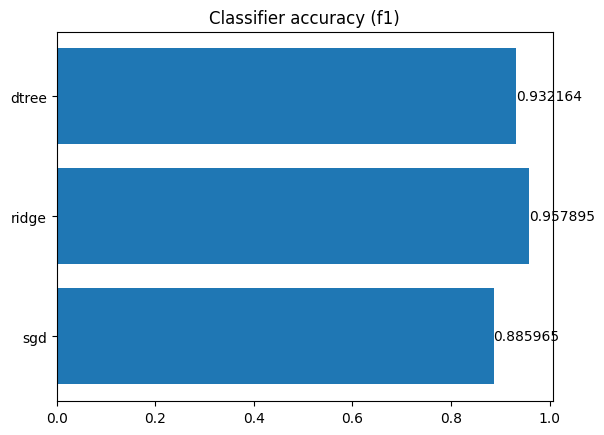

In [44]:
import numpy as np
accuracies = {}

iterations = 10

# Take an average accuracy score from 10 iterations, since they change between fits!

print("Comparing cross val score and accuracy of model to dummy classifier scores\n")
sgd_accuracies = []
ridge_accuracies = []
dtree_accuracies = []
for i in range(iterations):
    x_train, x_test, y_train, y_test = train_test_split(data_breast_cancer, y_all, test_size=0.3, shuffle=True)
    data = Data(x_train, y_train, x_test, y_test)

    scores = CompareToDummy(data, sgd)
    sgd_accuracies.append(scores[0])

    scores = CompareToDummy(data, ridge)
    ridge_accuracies.append(scores[0])

    scores = CompareToDummy(data, dtree)
    dtree_accuracies.append(scores[0])

accuracies["sgd"] = np.mean(sgd_accuracies)
accuracies["ridge"] = np.mean(ridge_accuracies)
accuracies["dtree"] = np.mean(dtree_accuracies)
print(accuracies)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
bars = ax.barh(np.arange(len(accuracies)), list(accuracies.values()))
plt.title("Classifier accuracy (f1)")
plt.yticks(range(len(accuracies)), list(accuracies.keys()))
ax.bar_label(bars)
#for i, v in enumerate(accuracies.values()):
#    ax.text(i, v+25, "%d" %v, ha="center")

Let's draw the confusion matrices

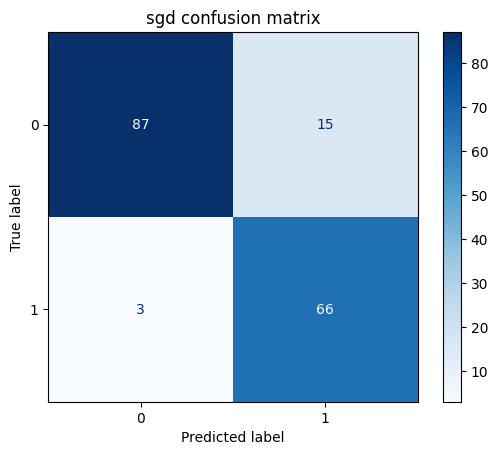

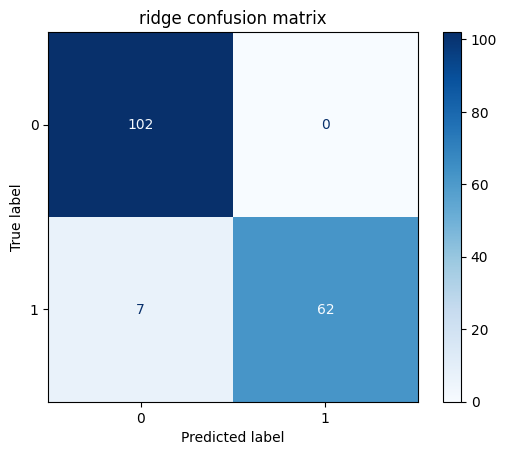

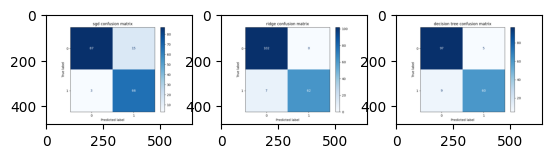

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_estimator(sgd, data.x_test, data.y_test, cmap=plt.cm.Blues)
display.ax_.set_title("sgd confusion matrix")
plt.savefig("images/results/sgd_conf.png")
display_2 = ConfusionMatrixDisplay.from_estimator(ridge, data.x_test, data.y_test, cmap=plt.cm.Blues)
display_2.ax_.set_title("ridge confusion matrix")
plt.savefig("images/results/ridge_conf.png")
display_3 = ConfusionMatrixDisplay.from_estimator(dtree, data.x_test, data.y_test, cmap=plt.cm.Blues)
display_3.ax_.set_title("decision tree confusion matrix")
plt.savefig("images/results/dtree_conf.png")

plt.clf()

import matplotlib.image as img
img_sgd = img.imread("images/results/sgd_conf.png")
img_ridge = img.imread("images/results/ridge_conf.png")
img_dtree = img.imread("images/results/dtree_conf.png")
plt.subplot(1, 3, 1)
plt.imshow(img_sgd)
plt.subplot(1, 3, 2)
plt.imshow(img_ridge)
plt.subplot(1, 3, 3)
plt.imshow(img_dtree)
plt.savefig("images/results/all_conf.png")



Try to run the algorithm on means and worst separately to see if we can get a better result with different data. For example, can we get better results from only considering the means or the worst features from the dataset?

In [187]:
X_train_means, X_test_means, Y_train_means, Y_test_means = train_test_split(data_breast_means, y_all, test_size = 0.25, shuffle=True)
X_train_worst, X_test_worst, Y_train_worst, Y_test_worst = train_test_split(data_breast_worst, y_all, test_size = 0.25, shuffle=True)
X_train_se, X_test_se, Y_train_se, Y_test_se = train_test_split(data_breast_se, y_all, test_size = 0.25, shuffle=True)

data_means = Data(X_train_means, Y_train_means, X_test_means, Y_test_means)
data_worst = Data(X_train_worst, Y_train_worst, X_test_worst, Y_test_worst)
data_se = Data(X_train_se, Y_train_se, X_test_se, Y_test_se)

grid_tuned = gridSearchRidge(data)
b, m = trainAndReport(grid_tuned, data)
grid_tuned = gridSearchRidge(data_means)
b, m = trainAndReport(grid_tuned, data_means)
grid_tuned = gridSearchRidge(data_worst)
b, m = trainAndReport(grid_tuned, data_worst)
grid_tuned = gridSearchRidge(data_se)
b, m = trainAndReport(grid_tuned, data_se)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
SEARCH TIME: 4.35 sec

Best model set found on train set:

	best parameters={'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	best 'f1_micro' score=0.9530232558139534
	best index=0

Best estimator CTOR:
	RidgeClassifier(alpha=0.01, solver='svd', tol=1e-05)

Grid scores ('f1_micro') on development set:
	[ 0]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'svd', 'tol': 1e-05}
	[ 1]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.0001}
	[ 2]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'svd', 'tol': 0.001}
	[ 3]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 1e-05}
	[ 4]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.0001}
	[ 5]: 0.953 (+/-0.073) for {'alpha': 0.01, 'solver': 'cholesky', 'tol': 0.001}
	[ 6]: 0.951 (+/-0.050) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 1e-05}
	[ 7]: 0.923 (+/-0.050) for {'alpha': 0.01, 'solver': 'lsqr', 'tol': 0.0001}
	[ 8]: 0.937 (+/-